In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxPH, DeepHit

from pycox.evaluation import EvalSurv
from pycox.simulations import SimStudyLinearPH

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
Y = lambda df_new: (df_new['duration'].values, df_new['event'].values)

# to standardize and get dependent variables 
x_num = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
x_cat = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 
standardize = [([num], StandardScaler()) for num in x_num]
label = [([cat], None) for cat in x_cat]

X_map = DataFrameMapper(standardize + label)

In [6]:
x_train = X_map.fit_transform(df_train).astype('float32') # x train
x_test= X_map.fit_transform(df_test).astype('float32') # x test
y_test = Y(df_test)
y_train = Y(df_train) # y train
time_test , status_test = Y(df_test) # test dependent variables Time & Status

# Neural Network

In [40]:
in_features = x_train.shape[1]
num_nodes = [64,32,16]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_cox = CoxPH(net, tt.optim.Adam(lr=0.01,amsgrad=True)) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data =(x_test,y_test),  val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 3.5037,	val_loss: 3.3377
1:	[0s / 0s],		train_loss: 3.3322,	val_loss: 3.1972
2:	[0s / 0s],		train_loss: 3.2593,	val_loss: 3.1244
3:	[0s / 0s],		train_loss: 3.3486,	val_loss: 3.1507
4:	[0s / 0s],		train_loss: 3.2824,	val_loss: 3.1075
5:	[0s / 0s],		train_loss: 3.2048,	val_loss: 3.0713
6:	[0s / 0s],		train_loss: 3.2831,	val_loss: 3.0704
7:	[0s / 0s],		train_loss: 3.1611,	val_loss: 3.0558
8:	[0s / 0s],		train_loss: 3.2247,	val_loss: 3.0450
9:	[0s / 0s],		train_loss: 3.0870,	val_loss: 3.0293
10:	[0s / 0s],		train_loss: 3.1188,	val_loss: 3.0114
11:	[0s / 0s],		train_loss: 3.2328,	val_loss: 3.0067
12:	[0s / 0s],		train_loss: 3.0891,	val_loss: 3.0406
13:	[0s / 0s],		train_loss: 3.1911,	val_loss: 3.0351
14:	[0s / 0s],		train_loss: 3.0856,	val_loss: 3.0197
15:	[0s / 0s],		train_loss: 3.0729,	val_loss: 3.0344
16:	[0s / 0s],		train_loss: 3.0377,	val_loss: 3.0084
17:	[0s / 0s],		train_loss: 3.1296,	val_loss: 3.0060
18:	[0s / 0s],		train_loss: 3.1028,	val_loss: 3.0568
19:

0.7680861980502822

<Figure size 864x864 with 0 Axes>

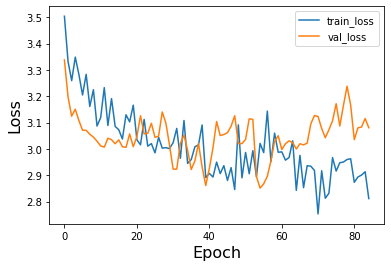

In [41]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.15170034150265269

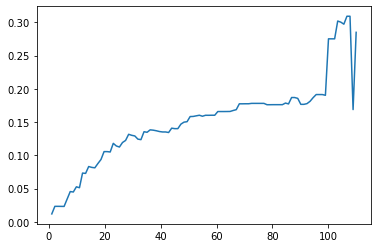

In [42]:
# integrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [43]:
# c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.8300212825969897

0.11176489604554052

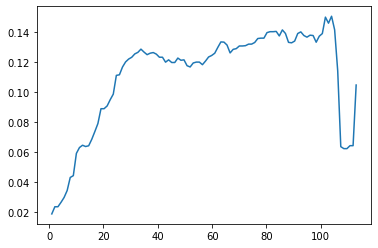

In [44]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [45]:
surv_cox

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
duration,,,,,,,,,,,,,,,,,,,,,
1,0.998702,0.994593,0.997839,0.996258,0.998563,0.998330,0.967597,0.989891,0.994152,0.989918,...,0.977088,0.999380,0.995459,0.997903,0.994087,0.987617,0.999864,0.986971,0.999391,0.999103
2,0.998261,0.992760,0.997104,0.994988,0.998074,0.997762,0.956808,0.986474,0.992169,0.986510,...,0.969409,0.999168,0.993918,0.997190,0.992082,0.983436,0.999818,0.982574,0.999184,0.998797
4,0.998028,0.991794,0.996717,0.994318,0.997817,0.997462,0.951166,0.984676,0.991124,0.984717,...,0.965384,0.999057,0.993106,0.996814,0.991027,0.981239,0.999793,0.980263,0.999075,0.998636
5,0.997794,0.990822,0.996327,0.993645,0.997557,0.997161,0.945517,0.982868,0.990074,0.982914,...,0.961346,0.998945,0.992289,0.996435,0.989965,0.979030,0.999769,0.977941,0.998965,0.998474
6,0.997324,0.988878,0.995547,0.992296,0.997038,0.996557,0.934303,0.979258,0.987972,0.979313,...,0.953309,0.998720,0.990654,0.995678,0.987840,0.974621,0.999719,0.973306,0.998744,0.998149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.861911,0.537778,0.780722,0.651207,0.848285,0.825900,0.023076,0.312697,0.511127,0.313679,...,0.070507,0.931444,0.594059,0.786443,0.507354,0.240328,0.984559,0.222992,0.932680,0.902366
107,0.861911,0.537778,0.780722,0.651207,0.848285,0.825900,0.023076,0.312697,0.511127,0.313679,...,0.070507,0.931444,0.594059,0.786443,0.507354,0.240328,0.984559,0.222992,0.932680,0.902366
108,0.861911,0.537778,0.780722,0.651207,0.848285,0.825900,0.023076,0.312697,0.511127,0.313679,...,0.070507,0.931444,0.594059,0.786443,0.507354,0.240328,0.984559,0.222992,0.932680,0.902366


In [46]:
model_cox.save_model_weights('myweights_DeepSurv.pt')
lz = torch.load('myweights_DeepSurv.pt')
print(lz)

OrderedDict([('net.0.linear.weight', tensor([[ 3.1332e-01,  1.5080e-01, -4.5315e-01, -9.3722e-01,  9.2984e-01,
         -2.1303e-01, -7.8933e-02,  2.7331e-01,  2.3404e-01,  1.2821e-01,
          7.2032e-03],
        [ 4.7549e-01, -3.2183e-01, -1.5028e+00, -7.6343e-01, -4.3067e-02,
         -2.5740e-01,  2.3953e-03,  3.3711e-01,  7.4343e-02,  3.3066e-01,
          1.9050e-01],
        [ 8.2926e-01, -7.4677e-02, -2.5338e-01,  5.6513e-01, -2.7800e-01,
          7.7534e-02, -4.3743e-01,  1.9519e-01, -4.8360e-01, -3.0901e-01,
          5.9731e-02],
        [-4.7766e-01, -1.6398e-02,  4.7733e-02, -8.5840e-01,  2.9863e-01,
         -6.7553e-01,  2.1614e-02, -1.0724e-02, -4.5786e-01, -1.0268e+00,
          4.3982e-01],
        [-5.1733e-01, -9.2708e-01, -1.2613e-01,  7.4578e-01, -5.8436e-01,
          8.3472e-02, -5.8498e-02,  6.1723e-02, -1.1804e-01, -6.0977e-01,
          3.0270e-01],
        [ 2.3732e-01,  1.7073e-01,  1.1399e-01, -1.9950e-01, -1.6093e-01,
         -1.0176e-01, -1.9284e-01,

In [47]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.83146860500863
The C-index Low 95% CI:0.8297474440158967
The C-index High 95% CI:0.8331897660013632


In [48]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.7718911067966118
The C-index Low 95% CI:0.769326318447966
The C-index High 95% CI:0.7744558951452576


# LASSO var

In [49]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [50]:
# to standardize and get dependent variables 
x_num = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
x_cat = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 
standardize = [([num], StandardScaler()) for num in x_num]
label = [([cat], None) for cat in x_cat]

X_map = DataFrameMapper(standardize + label)

x_train = X_map.fit_transform(df_train_lasso).astype('float32') # x train
x_test= X_map.fit_transform(df_test_lasso).astype('float32') # x test


In [53]:
in_features = x_train.shape[1]
num_nodes = [64,32,16]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_cox = CoxPH(net, tt.optim.Adam(lr=0.01,amsgrad=True)) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data =(x_test,y_test),  val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 3.6320,	val_loss: 3.0868
1:	[0s / 0s],		train_loss: 3.4127,	val_loss: 3.0756
2:	[0s / 0s],		train_loss: 3.2605,	val_loss: 3.1273
3:	[0s / 0s],		train_loss: 3.3230,	val_loss: 3.0728
4:	[0s / 0s],		train_loss: 3.2680,	val_loss: 3.0954
5:	[0s / 0s],		train_loss: 3.1555,	val_loss: 3.1007
6:	[0s / 0s],		train_loss: 3.2276,	val_loss: 3.1445
7:	[0s / 0s],		train_loss: 3.2013,	val_loss: 3.2271
8:	[0s / 0s],		train_loss: 3.1913,	val_loss: 3.2625
9:	[0s / 0s],		train_loss: 3.1708,	val_loss: 3.2038
10:	[0s / 0s],		train_loss: 3.1444,	val_loss: 3.1569
11:	[0s / 0s],		train_loss: 3.2261,	val_loss: 3.1475
12:	[0s / 0s],		train_loss: 3.1140,	val_loss: 3.1335
13:	[0s / 0s],		train_loss: 3.1392,	val_loss: 3.1115
14:	[0s / 0s],		train_loss: 3.0628,	val_loss: 3.1508
15:	[0s / 0s],		train_loss: 3.1525,	val_loss: 3.2128
16:	[0s / 0s],		train_loss: 3.0215,	val_loss: 3.2930
17:	[0s / 0s],		train_loss: 3.1728,	val_loss: 3.2155
18:	[0s / 0s],		train_loss: 3.0643,	val_loss: 3.0922
19:

0.7491021036428938

<Figure size 864x864 with 0 Axes>

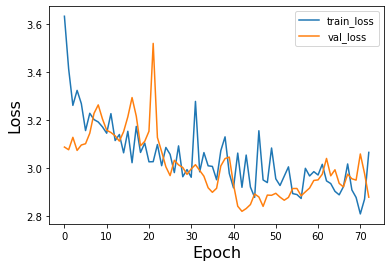

In [54]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.1553988691675732

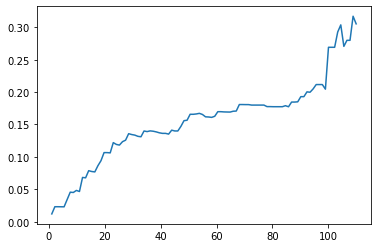

In [55]:
# integrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [56]:
# c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.8224057027103259

0.11735499691121276

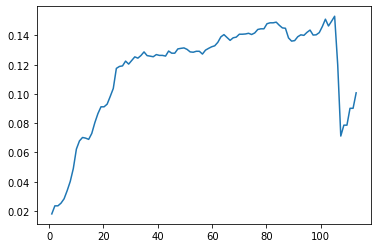

In [57]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [58]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.8256214298629193
The C-index Low 95% CI:0.8240008957997116
The C-index High 95% CI:0.827241963926127


In [59]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.7542899477665163
The C-index Low 95% CI:0.7517341211568946
The C-index High 95% CI:0.7568457743761379


# TNM

In [60]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [62]:
# to standardize and get dependent variables 
x_cat = ['T', 'N', 'M', 'Stage'] #categorical variables 
label = [([cat], None) for cat in x_cat]
X_map = DataFrameMapper(label)

x_train = X_map.fit_transform(df_train_tnm).astype('float32') # x train
x_test= X_map.fit_transform(df_test_tnm).astype('float32') # x test


In [112]:
in_features = x_train.shape[1]
num_nodes = [128,128,64,64,8]
out_features = 1
batch_norm = True
dropout = 0
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_cox = CoxPH(net, tt.optim.Adam(lr=0.01,amsgrad=True)) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data =(x_test,y_test),  val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 3.5018,	val_loss: 3.9739
1:	[0s / 0s],		train_loss: 3.4454,	val_loss: 3.1585
2:	[0s / 0s],		train_loss: 3.3352,	val_loss: 3.1500
3:	[0s / 0s],		train_loss: 3.3801,	val_loss: 3.1617
4:	[0s / 0s],		train_loss: 3.3089,	val_loss: 3.1744
5:	[0s / 0s],		train_loss: 3.4029,	val_loss: 3.2013
6:	[0s / 0s],		train_loss: 3.3505,	val_loss: 3.1998
7:	[0s / 0s],		train_loss: 3.3357,	val_loss: 3.1669
8:	[0s / 0s],		train_loss: 3.3435,	val_loss: 3.2141
9:	[0s / 0s],		train_loss: 3.3364,	val_loss: 3.1856
10:	[0s / 0s],		train_loss: 3.3201,	val_loss: 3.1765
11:	[0s / 0s],		train_loss: 3.4113,	val_loss: 3.2205
12:	[0s / 0s],		train_loss: 3.3803,	val_loss: 3.1709
13:	[0s / 0s],		train_loss: 3.3232,	val_loss: 3.1906
14:	[0s / 0s],		train_loss: 3.3994,	val_loss: 3.1951
15:	[0s / 0s],		train_loss: 3.3255,	val_loss: 3.2061
16:	[0s / 0s],		train_loss: 3.3430,	val_loss: 3.2145
17:	[0s / 0s],		train_loss: 3.3291,	val_loss: 3.1976
18:	[0s / 0s],		train_loss: 3.3612,	val_loss: 3.1577
19:

0.6593124679322729

<Figure size 864x864 with 0 Axes>

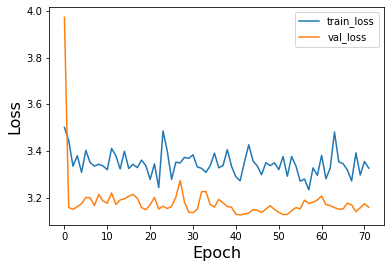

In [113]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.17337863135187004

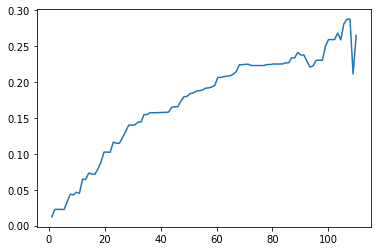

In [114]:
# integrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [115]:
# c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6957357880971307

0.17632757604417112

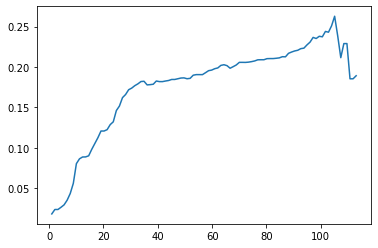

In [116]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [117]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.6949837716376174
The C-index Low 95% CI:0.6925105203891917
The C-index High 95% CI:0.697457022886043


In [118]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6660257059733844
The C-index Low 95% CI:0.6629845404367972
The C-index High 95% CI:0.6690668715099716
